In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import math
erf = np.vectorize(math.erf)
from b_spline import B_spline
from scipy.stats import multivariate_normal

def bake_cake(orientation, angle, resolution=(256,256), freq_min=.25, freq_max=.5, cake_type='basic', mean=[.0, .5], std=[[.005,0.0],[0.0,.0025]]):
    '''
        Generate cake wavelet mask
    '''
    
    X,Y = create_mesh(resolution)

    radial_coord, angular_coord = transform_cartesian_to_radial(X,Y)
    
    assert radial_coord.shape == angular_coord.shape
    assert np.alltrue(angular_coord>0)

    if cake_type == 'basic':
        values = basic_cake(radial_coord, angular_coord, orientation, angle, freq_max)
    elif cake_type == 'b_spline':
        values = b_spline_cake(radial_coord, angular_coord, orientation, angle, freq_max)
    elif cake_type == 'basic_bp':
        values = basic_bandpass(radial_coord, angular_coord, orientation, angle, freq_min, freq_max)
    elif cake_type == 'gabor':
        values = gabor(X, Y, orientation, np.array(mean), np.array(std))

    X,Y = transform_radial_to_cartesian(radial_coord, angular_coord)
    return np.stack([X, Y, values])

def create_mesh(resolution):
    '''
        Create a coordinate grid
    '''
    x_dim, y_dim = resolution
    
    X = np.linspace(-1, 1, x_dim)
    X = X[:, None].repeat(y_dim, axis=1)

    Y = np.linspace(-1, 1, y_dim)
    Y = Y[None, :].repeat(X.shape[0], axis=0)
    return X, Y

def b_spline_cake(  radial_coord, angular_coord, orientation, angle, freq_max, 
                    b_n = B_spline(2), radial_boundary_strength=2):
    '''
        Creates soft-boundary cake wavelet filters
    '''
    # angular resolution
    # equivalent to 2pi/N_slices
    s = angle

    # Shift center of spline to orientation
    shifted = (angular_coord-orientation)%(2*np.pi) - np.pi

    # Use erfc to create a soft radial boundary
    radial_boundary = (1-erf(radial_boundary_strength*(radial_coord-freq_max)))
    values = b_n(shifted/s) * radial_boundary
    
    return values

def basic_bandpass(radial_coord, angular_coord, orientation, angle, freq_min, freq_max):
    '''
        Create cake wavelets with hard boundaries
    '''
    values = np.zeros(angular_coord.shape)
    start = (orientation - angle/2) % (2*np.pi)
    end = (orientation + angle/2) % (2*np.pi)
    radial_idx = np.logical_and(freq_min<radial_coord, radial_coord<freq_max)
    if start>=end:
        # Catch if the angle overflows and loops around
        angle_idx = np.logical_or(start < angular_coord, angular_coord < end)
        
        idx = np.logical_and(angle_idx, radial_idx)
        values[idx] = 1
    else:
        # Between start and last
        angle_idx = np.logical_and(start < angular_coord, angular_coord < end)
        idx = np.logical_and(angle_idx,radial_idx)
        values[idx] = 1
    return values
def rotation_matrix(angle):
    '''
        Input:
            Angle - Rotation angle in Radians
        Output:
            mat - 2x2 Rotation matrix
    '''
    c = np.cos(angle)
    s = np.sin(angle)
    mat = np.array([[c , s],
                     [-s, c]])
    return mat

def gabor(X, Y, orientation, mean, cov):
    '''
        Create cake wavelets with hard boundaries
    '''
    values = np.zeros(X.shape)
    rot = rotation_matrix(orientation)
    mean = rot@mean
    # ?
    cov = rot @ cov @ rot.T
    coord = np.stack([X,Y], axis=-1)
    values = multivariate_normal(mean, cov).pdf(coord)
    return values

def basic_cake(radial_coord, angular_coord, orientation, angle, freq_max):
    '''
        Create cake wavelets with hard boundaries
    '''
    values = np.zeros(angular_coord.shape)
    start = (orientation - angle/2) % (2*np.pi)
    end = (orientation + angle/2) % (2*np.pi)
    if start>=end:
        # Catch if the angle overflows and loops around
        angle_idx = np.logical_or(start < angular_coord, angular_coord < end)
        radial_idx = radial_coord<freq_max
        idx = np.logical_and(angle_idx, radial_idx)
        values[idx] = 1
    else:
        # Between start and last
        angle_idx = np.logical_and(start < angular_coord, angular_coord < end)
        radial_idx = radial_coord<freq_max
        idx = np.logical_and(angle_idx,radial_idx)
        values[idx] = 1
    return values

def calculate_boundaries(max_radius, slices, radius_ticks):
    '''
        Calculates the orientation points for visualization
    '''
    radial_coord = np.arange(0, max_radius, radius_ticks)
    radial_coord = radial_coord[:, None].repeat(slices, axis=1)

    angular_coord = np.linspace(0, 360, slices, endpoint=False)
    angular_coord = angular_coord[:, None].repeat(radial_coord.shape[0], axis=1).T

    assert radial_coord.shape == angular_coord.shape

    values = np.ones(angular_coord.shape)

    X,Y = transform_radial_to_cartesian(radial_coord, angular_coord, degrees=True)
    
    return np.stack([X, Y])

def transform_cartesian_to_radial(X, Y):
    '''
        Convert to polar coordinates
        Input:
            X : x-domain discretized into N bins repeated M times (N x M)
            Y : y-domain discretized into M bins repeated N times (N x M)
        Return:
            r : The corresponding radial coordinate
            theta : The corresponding angular coordinate
    '''
    r = np.sqrt(X**2 + Y**2)
    ang = np.arctan2(X,Y) + np.pi
    return r, ang

def transform_radial_to_cartesian(rad, ang, degrees=False):
    '''
        Convert to Cartesian coordinates
        Input:
            r : The corresponding radial coordinate
            theta : The corresponding angular coordinate
        Return:
            X : x coordinate
            Y : y coordinate
    '''
    ang = ang
    if degrees==True:
        ang = np.deg2rad(ang)
    X = rad*np.cos(ang)
    Y = rad*np.sin(ang)
    return X, Y

def create_filter_bank(N_slices : int, resolution : tuple):
    '''
        Input:
            N_slices : 2pi/angle. Denoted as S.
            resolution : Shape of image (N, M)
        Output:
            filters : 1 x 1 x S x N x M Tensor for elementwise product with batch
    '''
    angle = 2*np.pi
    angles = np.linspace(0, 2*np.pi, N_slices, endpoint=False)
    filters = []
    # Create a filter for every orientation of a slice
    # This is equivalent to rotating the image and applying it to the image
    for orientation in angles:
        X, Y, val = bake_cake(orientation, angle, cake_type='b_spline', resolution=resolution)
        # Transform to match fft convensions
        val = transform_for_ifft(val)
        filters += [torch.tensor(val)]
    return torch.stack(filters).unsqueeze(0).unsqueeze(0)

def transform_for_ifft(img):
    '''
        ifft expects positive frequencies 0:N followed by negative frequencies 0:N
    '''
    shape = img.shape
    N, M = shape
    img_2 = np.zeros(shape)
    pp_freqs = img[N//2:, M//2:]
    pn_freqs = img[N//2:, :M//2]
    np_freqs = img[:N//2, M//2:]
    nn_freqs = img[:N//2, :M//2]
    
    img_2 = np.zeros(shape)
    img_2[:N//2, :M//2] = pp_freqs
    img_2[:N//2, M//2:] = pn_freqs
    img_2[N//2:, :M//2] = np_freqs
    img_2[N//2:, M//2:] = nn_freqs
    return img_2

In [5]:
class CakeLiftingLayer(torch.nn.Module):
    def __init__(self, slices, resolution) -> None:
        super().__init__()

        # 1 x 1 x S x N x M
        self.filters = create_filter_bank(slices, resolution)
        
    def forward(self, x):
        '''
            Input:
                x - B x C x N x M Tensor
            Return
                y - B x C x S x N x M Tensor of 
        '''
        x_ = torch.fft.fft2(x)        
        x_ = x_.unsqueeze(-3) # B x C x 1 x N x M
        y = x_ * self.filters # B x C x S x N x M
        
        return y
print(torch.__version__)
layer = CakeLiftingLayer(20, (32,32))
x = torch.ones((16, 3, 32, 32))
layer(x).shape
        

1.13.0+cpu


torch.Size([16, 3, 20, 32, 32])

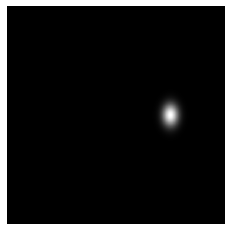

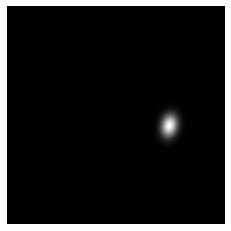

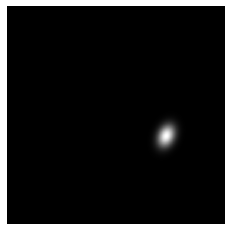

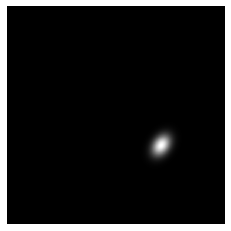

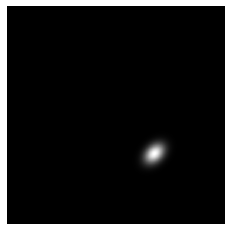

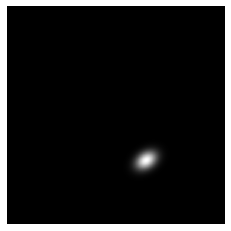

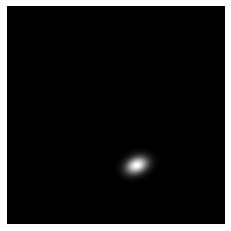

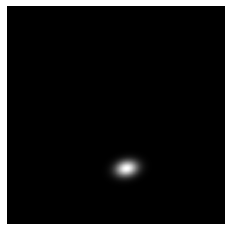

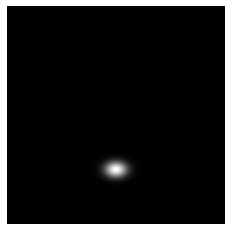

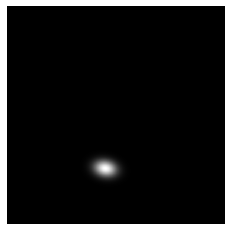

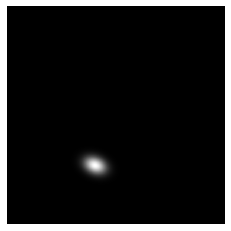

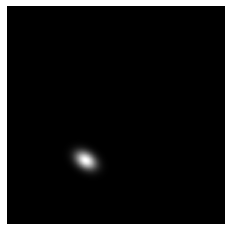

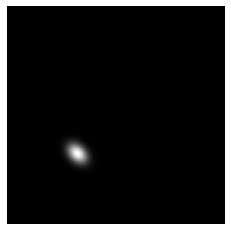

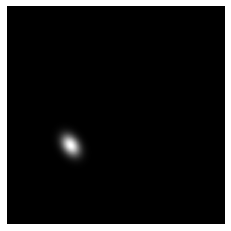

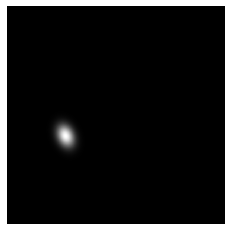

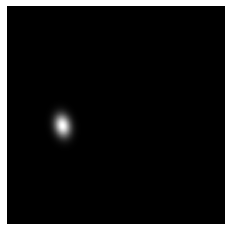

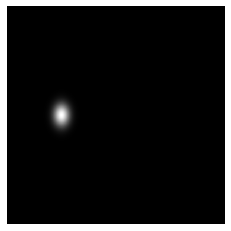

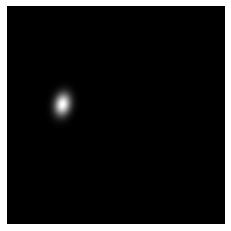

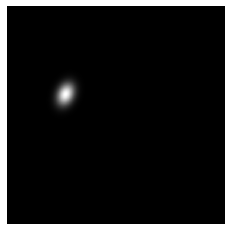

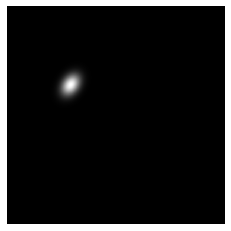

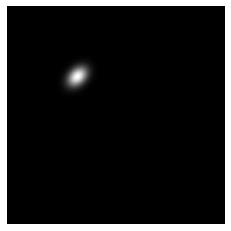

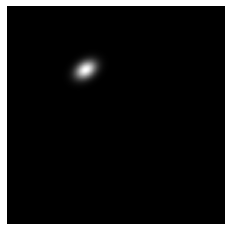

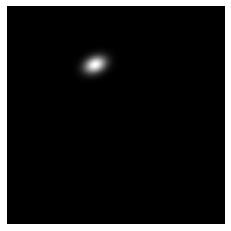

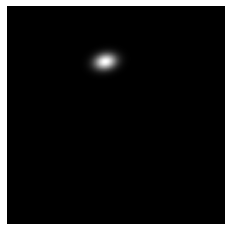

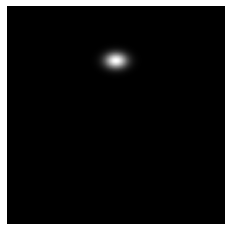

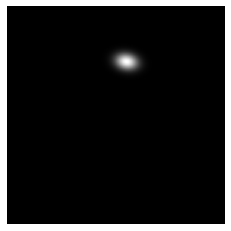

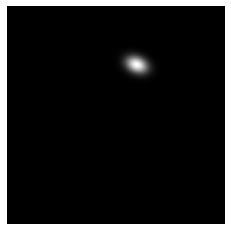

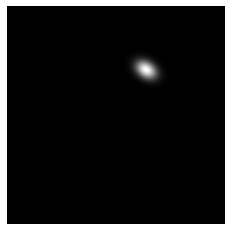

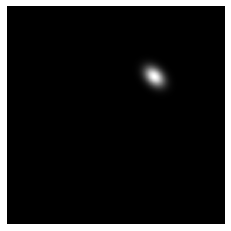

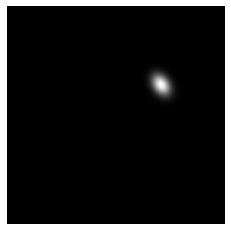

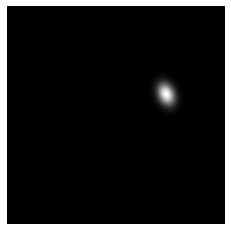

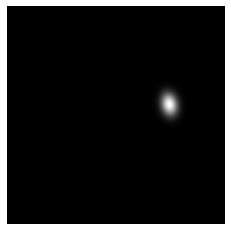

<Figure size 432x288 with 0 Axes>

In [43]:
slices = 32
angle = 2*np.pi/slices
angles = np.linspace(0,2*np.pi, slices, endpoint=False)
filenames = []
c_type = 'gabor'
images = []

for i, orientation in enumerate(angles):
    X, Y, val = bake_cake(orientation, angle, cake_type=c_type, resolution=(1024,1024))

    bx, by = calculate_boundaries(1, slices, radius_ticks=.5)
    images += [val]

    plt.imshow(val, vmax=val.max(), cmap='gray')
    plt.axis('off')

    filenames+=['/Thesis/images/cake_'+str(i) +'.png']
    plt.savefig('/Thesis/images/cake_'+str(i) +'.png')
    plt.show()
    plt.clf()

import imageio
with imageio.get_writer('./cake.gif', mode='I', duration=.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

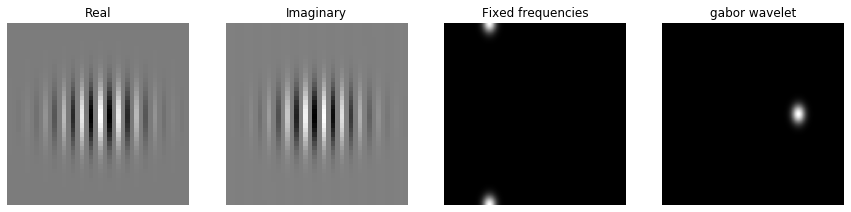

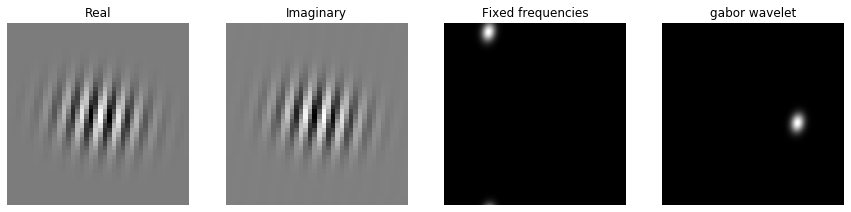

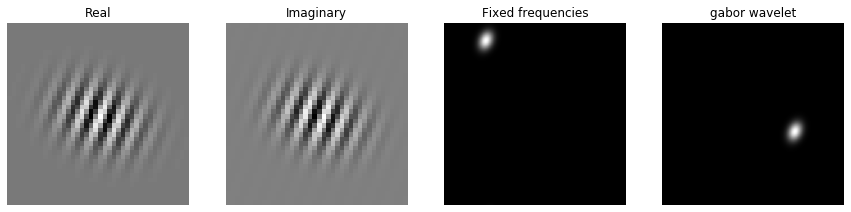

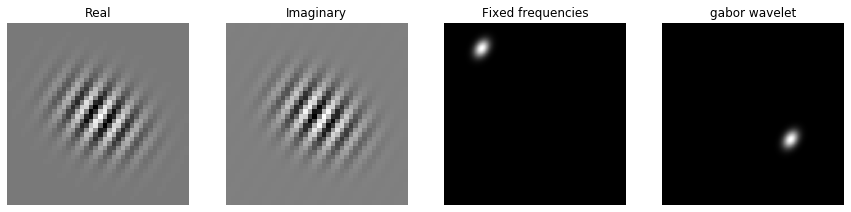

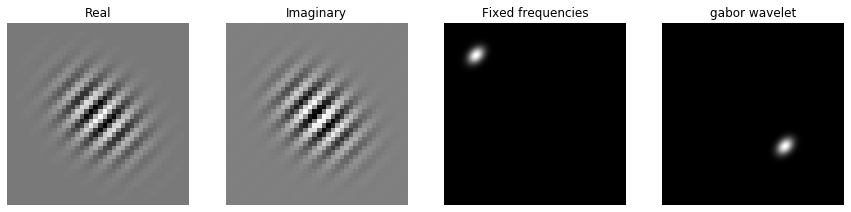

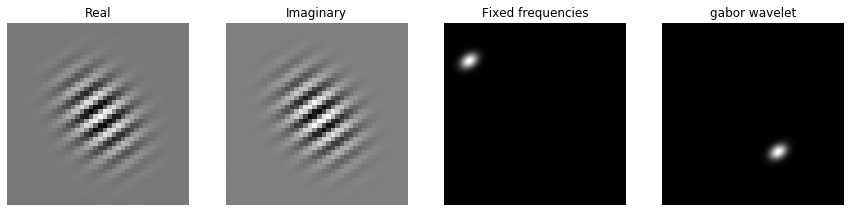

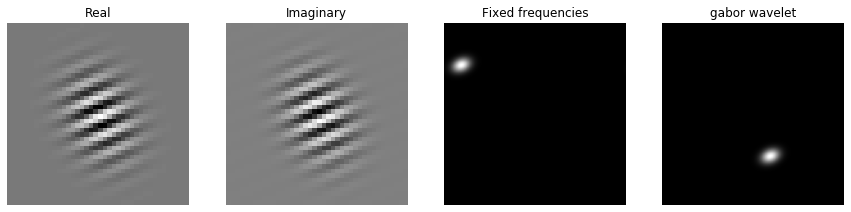

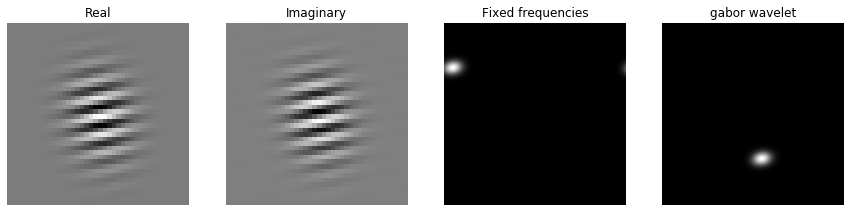

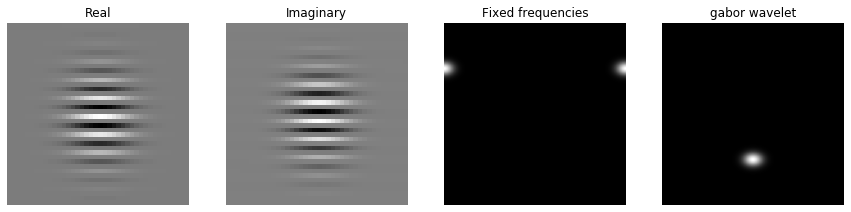

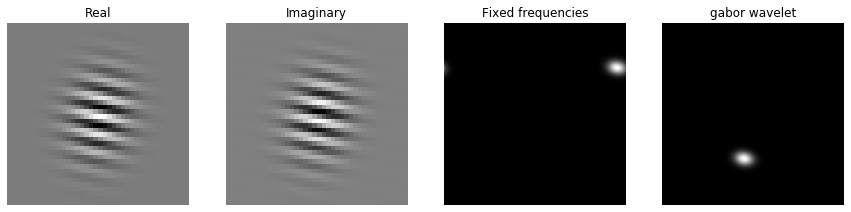

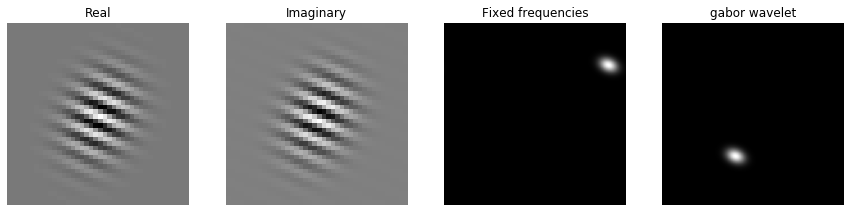

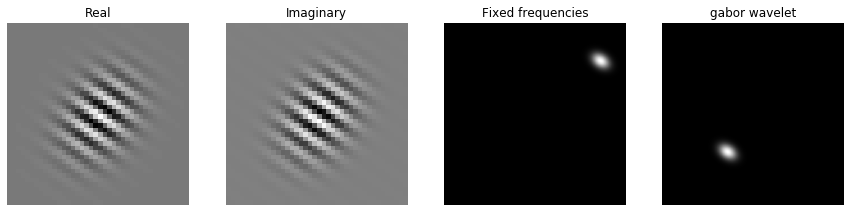

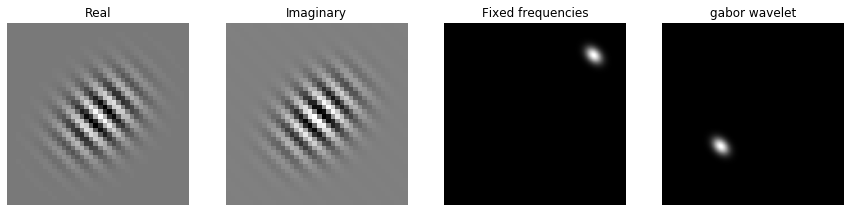

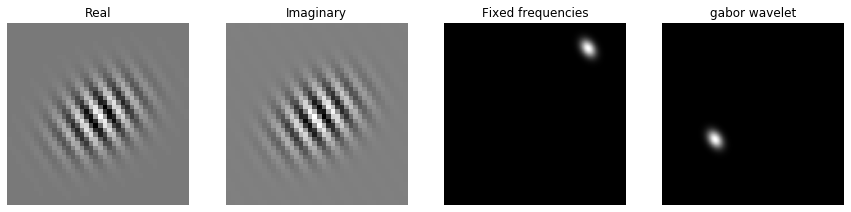

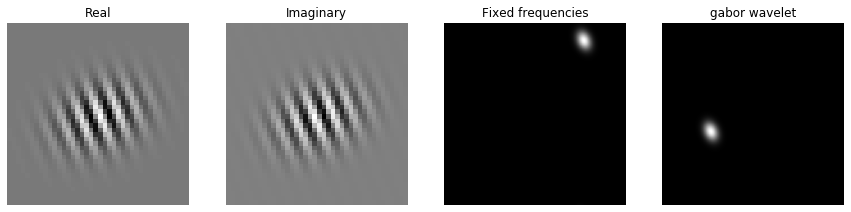

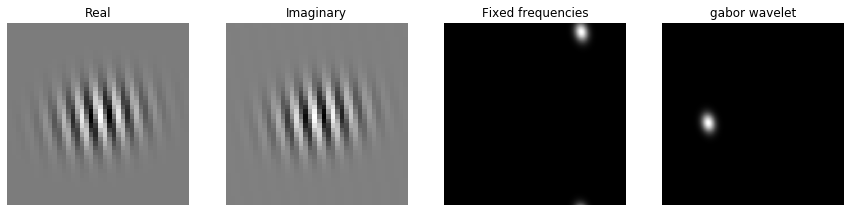

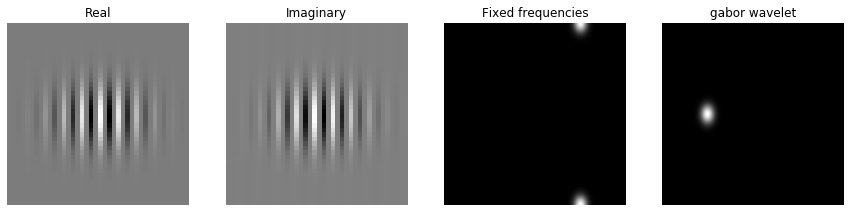

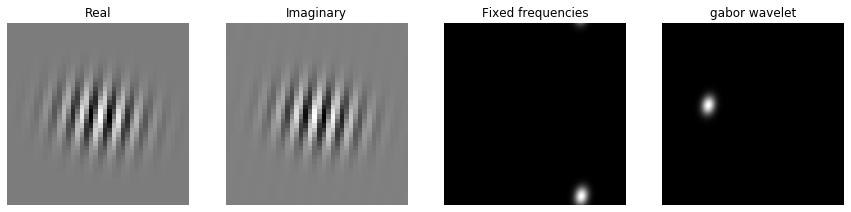

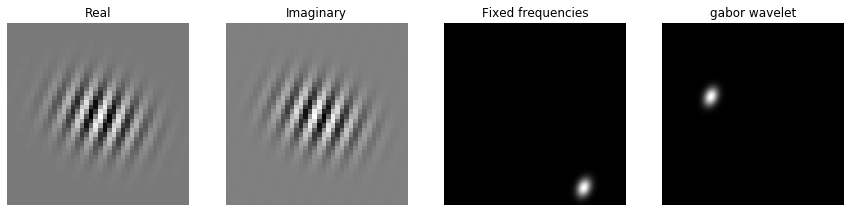

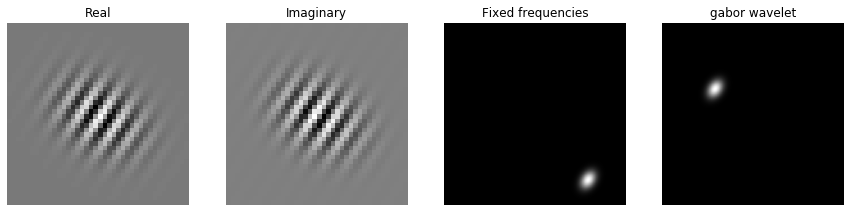

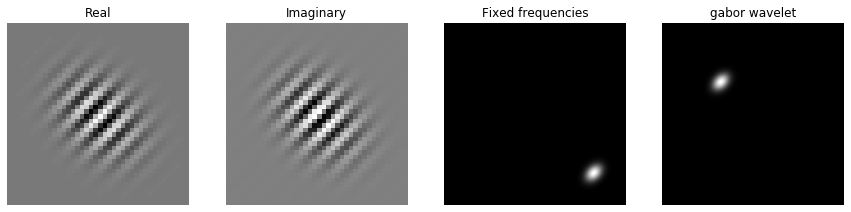

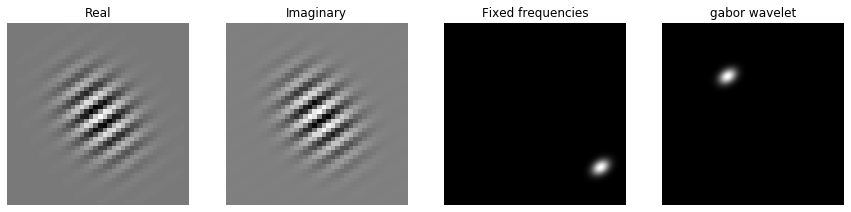

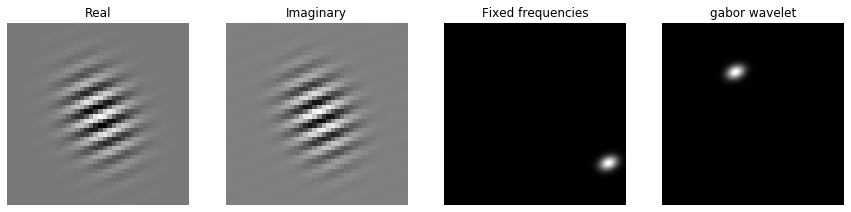

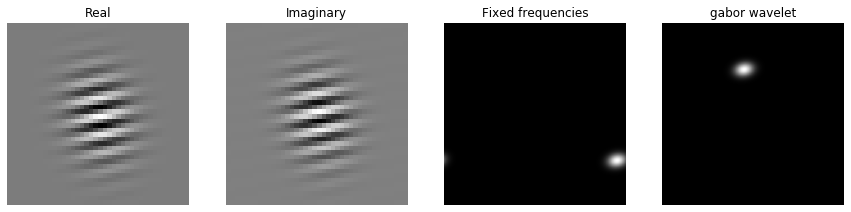

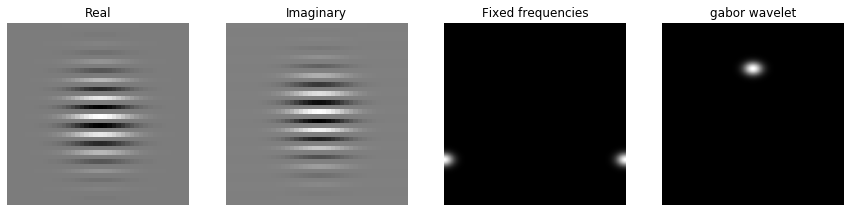

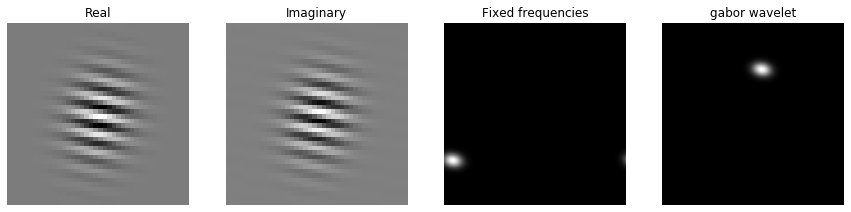

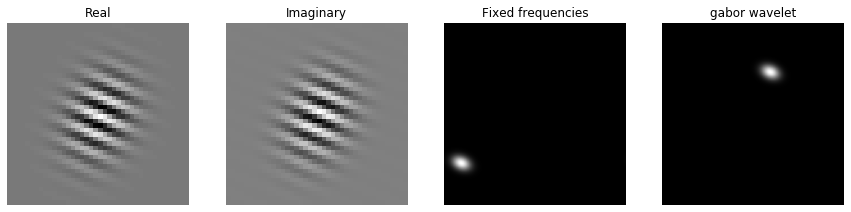

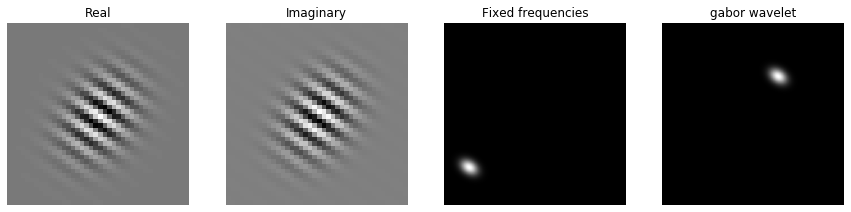

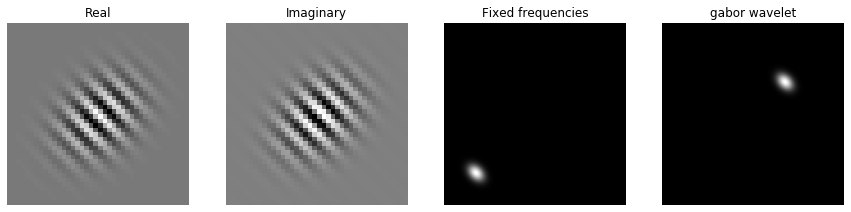

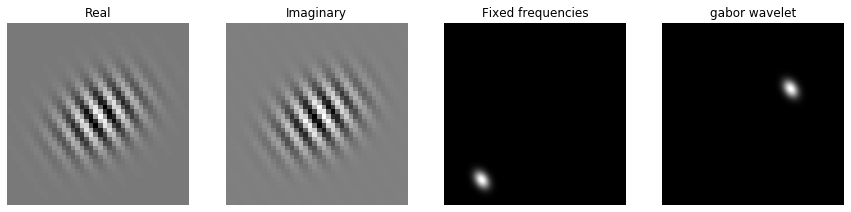

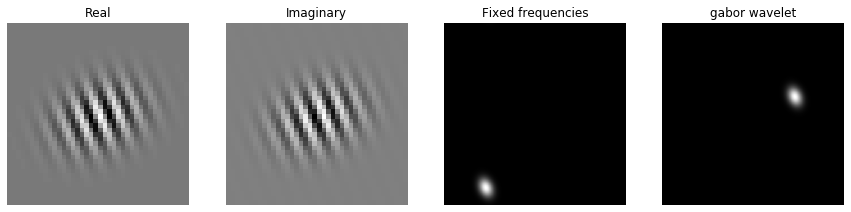

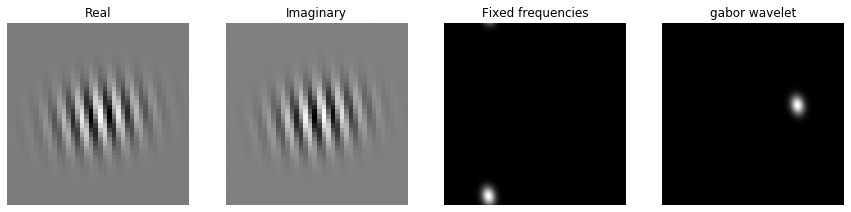

['/Thesis/images/ifft_0.png', '/Thesis/images/ifft_1.png', '/Thesis/images/ifft_2.png', '/Thesis/images/ifft_3.png', '/Thesis/images/ifft_4.png', '/Thesis/images/ifft_5.png', '/Thesis/images/ifft_6.png', '/Thesis/images/ifft_7.png', '/Thesis/images/ifft_8.png', '/Thesis/images/ifft_9.png', '/Thesis/images/ifft_10.png', '/Thesis/images/ifft_11.png', '/Thesis/images/ifft_12.png', '/Thesis/images/ifft_13.png', '/Thesis/images/ifft_14.png', '/Thesis/images/ifft_15.png', '/Thesis/images/ifft_16.png', '/Thesis/images/ifft_17.png', '/Thesis/images/ifft_18.png', '/Thesis/images/ifft_19.png', '/Thesis/images/ifft_20.png', '/Thesis/images/ifft_21.png', '/Thesis/images/ifft_22.png', '/Thesis/images/ifft_23.png', '/Thesis/images/ifft_24.png', '/Thesis/images/ifft_25.png', '/Thesis/images/ifft_26.png', '/Thesis/images/ifft_27.png', '/Thesis/images/ifft_28.png', '/Thesis/images/ifft_29.png', '/Thesis/images/ifft_30.png', '/Thesis/images/ifft_31.png']


In [46]:
import PIL.Image as Image
import torch

def create_gif(filenames, out_path):
    with imageio.get_writer(out_path, mode='I', duration=.5) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            
    
def transform_for_ifft(img):
    '''
        ifft expects positive frequencies 0:N followed by negative frequencies 0:N
    '''
    shape = img.shape
    N, M = shape
    img_2 = np.zeros(shape)
    pp_freqs = img[N//2:, M//2:]
    pn_freqs = img[N//2:, :M//2]
    np_freqs = img[:N//2, M//2:]
    nn_freqs = img[:N//2, :M//2]
    
    img_2 = np.zeros(shape)
    img_2[:N//2, :M//2] = pp_freqs
    img_2[:N//2, M//2:] = pn_freqs
    img_2[N//2:, :M//2] = np_freqs
    img_2[N//2:, M//2:] = nn_freqs
    return img_2

def recenter(img):
    shape = img.shape
    N, M = shape
    img_2 = np.zeros(shape, dtype=complex)
    img_2[N//2:,M//2:] = img[:N//2,:M//2]
    img_2[:N//2,M//2:] = img[N//2:,:M//2]
    img_2[N//2:,:M//2] = img[:N//2,M//2:]
    img_2[:N//2,:M//2] = img[N//2:,M//2:]
    return img_2

iffts = []
N,M = images[0].shape
for i,img in enumerate(images):
    # img = np.fft.ifft2(img+img*1j)
    
    img_2 = transform_for_ifft(img)
    ifft = np.fft.ifft2(img_2)
    ifft = recenter(ifft)
    
    fig,axs = plt.subplots(1,4, figsize=(15,15))
    for ax in axs:
        ax.axis('off')

    axs[0].set_title('Real')
    axs[0].imshow(np.real(ifft[N//2-20:N//2+20,M//2-20:M//2+20]), cmap='gray')

    axs[1].set_title('Imaginary')
    axs[1].imshow(np.imag(ifft[N//2-20:N//2+20,M//2-20:M//2+20]), cmap='gray')
    
    axs[2].set_title('Fixed frequencies')
    axs[2].imshow(img_2, cmap='gray')

    axs[3].set_title( c_type + ' wavelet' )
    axs[3].imshow(img, cmap='gray')
    


    iffts+=['/Thesis/images/ifft_'+str(i) +'.png']
    plt.savefig('/Thesis/images/ifft_'+str(i) +'.png')
    plt.show()
    
print(iffts)
create_gif(iffts, './iffts.gif')


In [143]:
ar = np.arange(10)
l = ar[1:5:-1]
print(l)

[]
